In [1]:
import mne
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from preprocessing import load_file_data, filter_eeg_data
from dataset import EEGDataset, epoch_data, k_fold_validation_split
from snn import SNN, SpikingModel, train_model, test_model

# Focus Data Preparation

Creating RawArray with float64 data, n_channels=8, n_times=10717
    Range : 0 ... 10716 =      0.000 ...    42.864 secs
Ready.
Using matplotlib as 2D backend.


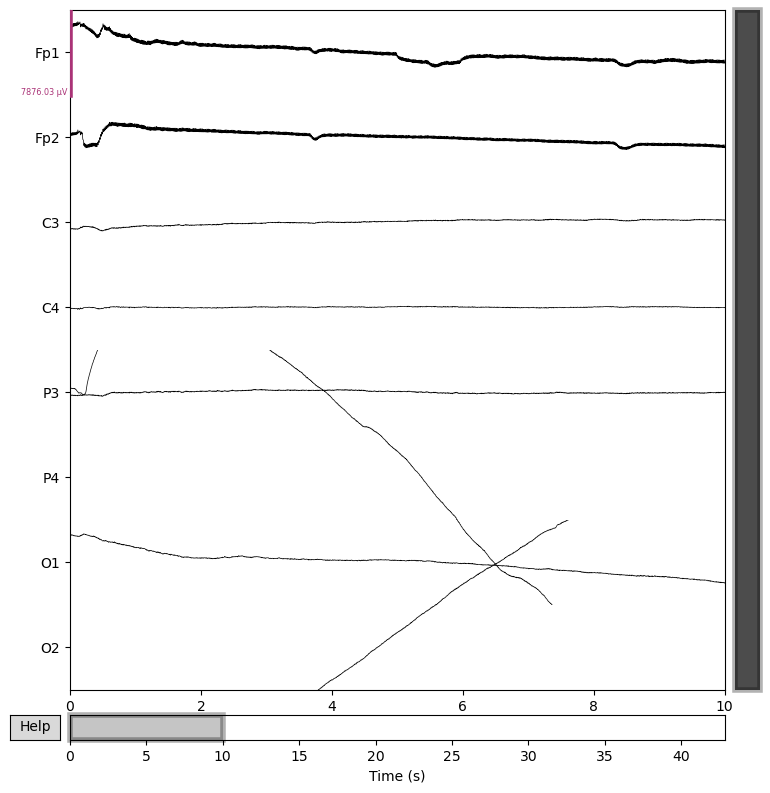

In [2]:
raw_focus = load_file_data("OpenBCISession_cc_focus1/OpenBCI-RAW.csv")
raw_focus.plot(n_channels=8, scalings='auto');

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


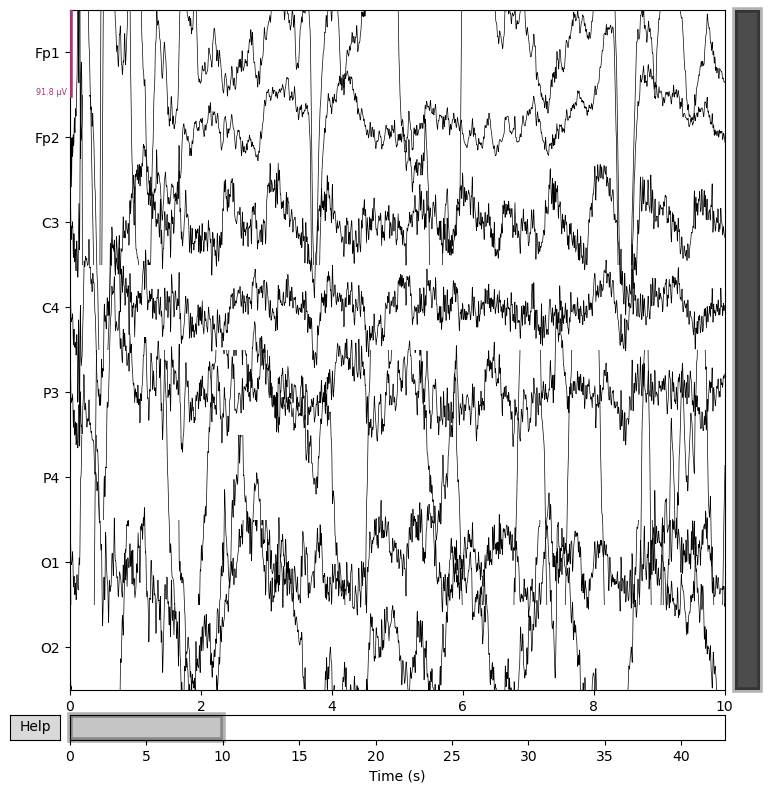

In [3]:
# Apply notch filter to remove 60Hz noise
filtered = filter_eeg_data(raw_focus)
filtered.plot(n_channels=8, scalings='auto');

In [4]:
# Epoch data into 0.5 second windows
epochs = epoch_data(filtered, time_window=0.5, overlap=0)
print(epochs.get_data().shape)
print(epochs.get_data()[0].shape)

Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 85 events and 126 original time points ...
0 bad epochs dropped
(85, 8, 126)
(8, 126)


In [5]:
# psd = []

# for i in range(len(epochs)):
#     # Compute the power spectral density of each channel
#     psd += [epochs[i].compute_psd(method='multitaper', fmin=1, fmax=50)]
#     # Plot the power spectral density
#     psd[i].plot(picks=[0, 1, 2, 3, 4, 5, 6, 7], average=False);
#     plt.show()

In [6]:
# deltas = []
# thetas = []
# alphas = []
# betas = []
# gammas = []

# for i in range(len(epochs)):
#     # Get delta, theta, alpha, beta, and gamma bands
#     deltas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=1, fmax=4).mean()]
#     thetas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=4, fmax=8).mean()]
#     alphas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=8, fmax=13).mean()]
#     betas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=13, fmax=30).mean()]
#     gammas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=30, fmax=50).mean()]

# print(deltas)
# print(thetas)
# print(alphas)
# print(betas)
# print(gammas)

In [7]:
# # Make new dataframe with the delta, theta, alpha, beta, and gamma bands
# focus_df = pd.DataFrame({'delta': deltas, 'theta': thetas, 'alpha': alphas, 'beta': betas, 'gamma': gammas})

# # Add new column with label = 'Focus'
# focus_df['focus'] = 1

# focus_df

In [8]:
# Make new data frame with 8 channels of data
focus_df = pd.DataFrame(epochs.get_data()[0].transpose(), columns=['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8'])

# Add new column with label = 1 for focus
focus_df['focus'] = 1

display(focus_df)

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,focus
0,-1.490778e-19,-1.436568e-18,2.574980e-19,4.472334e-19,2.737610e-18,-3.388132e-18,-5.421011e-20,-1.626303e-17,1
1,-7.543035e-05,-7.876594e-05,3.270423e-05,2.144511e-05,2.709817e-05,-3.357432e-05,2.493089e-05,-4.170365e-06,1
2,-6.310416e-05,-7.769586e-05,3.132911e-05,2.092481e-05,2.783690e-05,-7.355108e-05,2.909663e-05,-1.782426e-05,1
3,7.621806e-06,-2.624679e-05,3.064058e-06,2.222042e-06,6.799198e-06,-1.124966e-04,1.501579e-05,-3.317405e-05,1
4,4.437784e-05,-9.444032e-06,-1.772559e-05,-1.346559e-05,-1.062236e-05,-1.408138e-04,1.367515e-06,-3.775339e-05,1
...,...,...,...,...,...,...,...,...,...
121,1.824424e-04,-1.839578e-04,-2.318736e-04,-5.786978e-05,-1.576906e-04,6.107368e-04,8.283007e-06,-8.227120e-04,1
122,2.268896e-04,-1.450087e-04,-2.519104e-04,-6.983424e-05,-1.835940e-04,6.254123e-04,-2.066882e-05,-7.929684e-04,1
123,3.137955e-04,-1.001605e-04,-2.615812e-04,-7.540701e-05,-1.990404e-04,6.337361e-04,-5.173283e-05,-7.627629e-04,1
124,4.313208e-04,-3.921884e-05,-2.577112e-04,-7.081819e-05,-1.965957e-04,6.256920e-04,-6.771938e-05,-7.458050e-04,1


# No Focus Data Preparation

Creating RawArray with float64 data, n_channels=8, n_times=7543
    Range : 0 ... 7542 =      0.000 ...    30.168 secs
Ready.


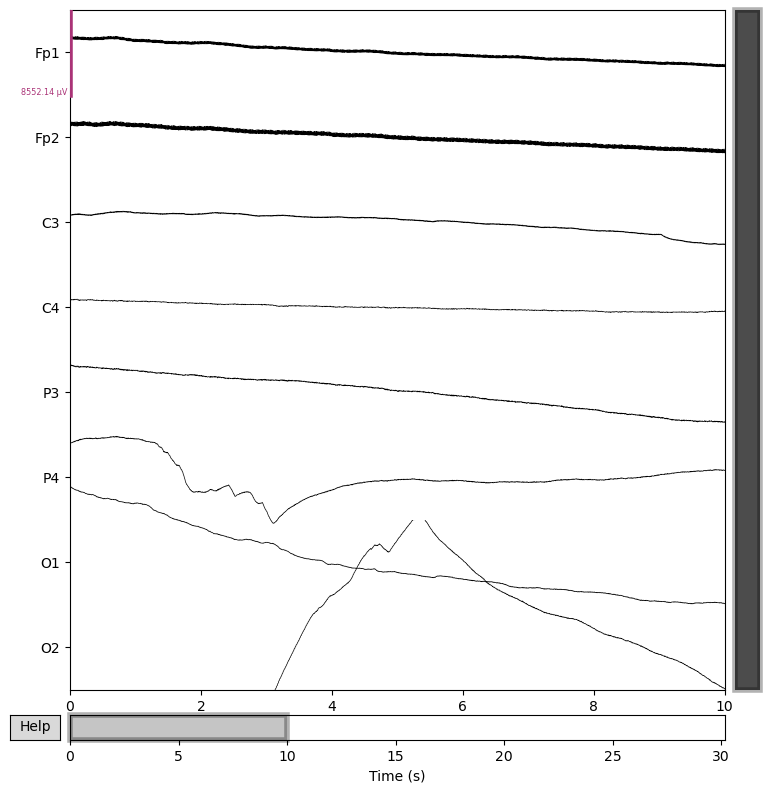

In [9]:
raw_focus = load_file_data("OpenBCISession_cc_nofocus1/OpenBCI-RAW.csv")
raw_focus.plot(n_channels=8, scalings='auto');

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 sec)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished


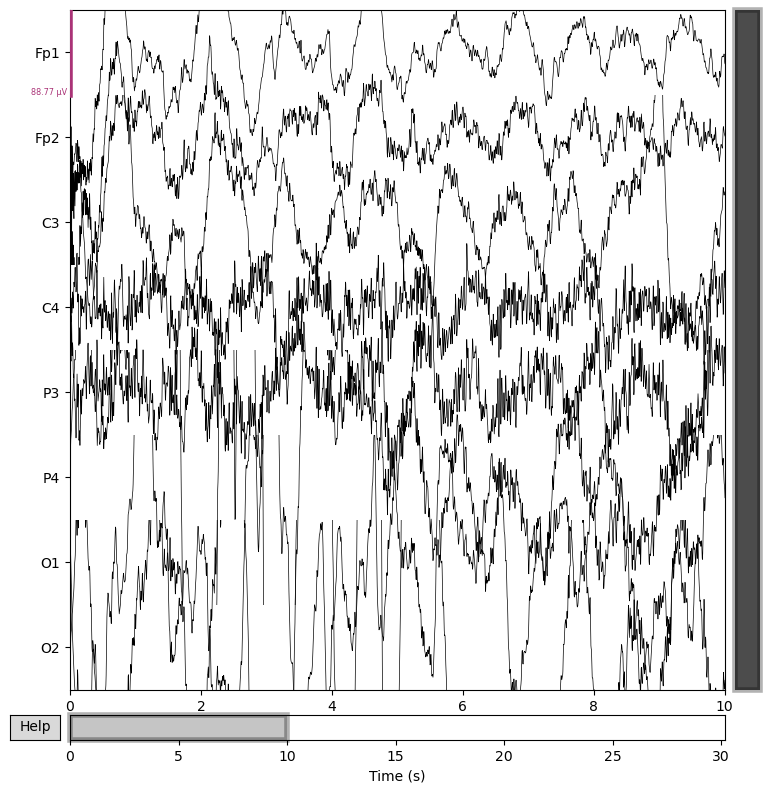

In [10]:
# Apply notch filter to remove 60Hz noise
filtered = filter_eeg_data(raw_focus)
filtered.plot(n_channels=8, scalings='auto');

In [11]:
# Epoch data into 1 second windows
epochs = epoch_data(filtered, time_window=0.5, overlap=0)
print(epochs.get_data().shape)
print(epochs.get_data()[0].shape)

Not setting metadata
60 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 60 events and 126 original time points ...
0 bad epochs dropped
(60, 8, 126)
(8, 126)


In [12]:
# psd = []

# for i in range(len(epochs)):
#     # Compute the power spectral density of each channel
#     psd += [epochs[i].compute_psd(method='multitaper', fmin=1, fmax=50)]
#     # Plot the power spectral density
#     # psd[i].plot(picks=[0, 1, 2, 3, 4, 5, 6, 7], average=False);
#     # plt.show()

In [13]:
# deltas = []
# thetas = []
# alphas = []
# betas = []
# gammas = []

# for i in range(len(epochs)):
#     # Get delta, theta, alpha, beta, and gamma bands
#     deltas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=1, fmax=4).mean()]
#     thetas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=4, fmax=8).mean()]
#     alphas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=8, fmax=13).mean()]
#     betas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=13, fmax=30).mean()]
#     gammas += [psd[i].get_data(picks=[0, 1, 2, 3, 4, 5, 6, 7], fmin=30, fmax=50).mean()]

# print(deltas)
# print(thetas)
# print(alphas)
# print(betas)
# print(gammas)

In [14]:
# # Make new dataframe with the delta, theta, alpha, beta, and gamma bands
# nofocus_df = pd.DataFrame({'delta': deltas, 'theta': thetas, 'alpha': alphas, 'beta': betas, 'gamma': gammas})

# # Add new column with label = 'No Focus'
# nofocus_df['focus'] = 0

# nofocus_df

In [15]:
# Make new data frame with 8 channels of data
nofocus_df = pd.DataFrame(epochs.get_data()[0].transpose(), columns=['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8'])

# Add new columns with label = 0 for no focus
nofocus_df['focus'] = 0

display(nofocus_df)

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,focus
0,1.084202e-18,4.282599e-18,-9.147956e-19,-3.252607e-19,-1.680513e-18,-1.084202e-19,3.361027e-18,3.577867e-18,0
1,-2.218928e-04,-3.239364e-04,4.829874e-06,3.090219e-05,6.156102e-05,2.340136e-05,8.005278e-06,2.261117e-05,0
2,-2.443277e-04,-3.468581e-04,1.920311e-05,2.429865e-05,6.723655e-05,4.291272e-05,3.996605e-06,4.167447e-05,0
3,-1.291191e-04,-1.614667e-04,3.562497e-05,-5.183554e-06,3.759599e-05,5.486878e-05,-1.043018e-05,5.368188e-05,0
4,-8.196920e-05,-7.905206e-05,4.077312e-05,-1.640676e-05,3.238012e-05,5.938704e-05,-2.449987e-05,5.839090e-05,0
...,...,...,...,...,...,...,...,...,...
121,-1.865040e-05,-2.475493e-05,1.121804e-05,-3.394366e-05,-2.827247e-05,9.006893e-05,-1.888469e-04,-7.249478e-05,0
122,-2.218612e-05,-3.321661e-05,6.475716e-07,-1.899176e-05,-5.322633e-06,8.264258e-05,-1.986413e-04,-8.487981e-05,0
123,-2.258342e-05,-4.496121e-05,-5.543010e-06,-2.471654e-06,1.280994e-05,7.213896e-05,-2.013356e-04,-1.006672e-04,0
124,-1.324235e-05,-3.990574e-05,-1.708622e-06,-4.496639e-06,5.720488e-06,7.015001e-05,-1.992198e-04,-1.068185e-04,0


# Create Dataset and Dataloaders

In [16]:
from sklearn.model_selection import train_test_split

train_focus, test_focus = train_test_split(focus_df, test_size=0.2, shuffle=False)

train_nofocus, test_nofocus = train_test_split(nofocus_df, test_size=0.2, shuffle=False)

# Concatenate the focus and no focus dataframes
train_df = pd.concat([train_focus, train_nofocus])
test_df = pd.concat([test_focus, test_nofocus])

display(train_df.shape)
display(test_df.shape)
display(train_df)
display(test_df)

(200, 9)

(52, 9)

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,focus
0,-1.490778e-19,-1.436568e-18,2.574980e-19,4.472334e-19,2.737610e-18,-3.388132e-18,-5.421011e-20,-1.626303e-17,1
1,-7.543035e-05,-7.876594e-05,3.270423e-05,2.144511e-05,2.709817e-05,-3.357432e-05,2.493089e-05,-4.170365e-06,1
2,-6.310416e-05,-7.769586e-05,3.132911e-05,2.092481e-05,2.783690e-05,-7.355108e-05,2.909663e-05,-1.782426e-05,1
3,7.621806e-06,-2.624679e-05,3.064058e-06,2.222042e-06,6.799198e-06,-1.124966e-04,1.501579e-05,-3.317405e-05,1
4,4.437784e-05,-9.444032e-06,-1.772559e-05,-1.346559e-05,-1.062236e-05,-1.408138e-04,1.367515e-06,-3.775339e-05,1
...,...,...,...,...,...,...,...,...,...
95,-6.540711e-05,-1.074301e-04,-4.658318e-05,-6.264594e-06,-1.216743e-05,1.159327e-04,-1.282488e-04,3.978774e-05,0
96,-5.237035e-05,-9.196956e-05,-3.983353e-05,-1.279277e-05,-2.040958e-05,1.249657e-04,-1.325415e-04,4.615896e-05,0
97,-5.409679e-05,-9.778398e-05,-3.846582e-05,-1.282302e-05,-2.016231e-05,1.283949e-04,-1.377622e-04,4.543667e-05,0
98,-6.119151e-05,-1.103162e-04,-4.000195e-05,-1.145435e-05,-1.432768e-05,1.257048e-04,-1.414390e-04,3.780162e-05,0


,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,focus
100,-0.000444,-0.001176,-1.128760e-05,-0.000047,-9.032141e-05,0.000123,0.000148,-0.000841,1
101,-0.000469,-0.001175,-2.421354e-05,-0.000057,-9.529428e-05,0.000158,0.000136,-0.000848,1
102,-0.000495,-0.001168,-4.065607e-05,-0.000068,-1.025038e-04,0.000196,0.000126,-0.000851,1
103,-0.000509,-0.001150,-5.443960e-05,-0.000078,-1.071234e-04,0.000233,0.000121,-0.000854,1
104,-0.000505,-0.001119,-5.994706e-05,-0.000080,-1.049107e-04,0.000264,0.000121,-0.000862,1
105,-0.000492,-0.001079,-6.212871e-05,-0.000079,-9.899690e-05,0.000289,0.000123,-0.000874,1
106,-0.000485,-0.001041,-7.156043e-05,-0.000081,-9.762481e-05,0.000316,0.000121,-0.000885,1
107,-0.000482,-0.001006,-9.018956e-05,-0.000090,-1.041231e-04,0.000347,0.000114,-0.000891,1
108,-0.000473,-0.000968,-1.089706e-04,-0.000096,-1.132911e-04,0.000379,0.000105,-0.000895,1
109,-0.000452,-0.000922,-1.214290e-04,-0.000093,-1.197176e-04,0.000407,0.000095,-0.000898,1


In [17]:
# Normalize the data
# train_df[:, :-1] = (train_df[:, :-1] - train_df[:, :-1].mean()) / train_df[:, :-1].std()
# test_df[:, :-1] = (test_df[:, :-1] - test_df[:, :-1].mean()) / test_df[:, :-1].std()

# Normalize all columns except the last
train_df.iloc[:, :-1] = (train_df.iloc[:, :-1] - train_df.iloc[:, :-1].mean()) / train_df.iloc[:, :-1].std()
test_df.iloc[:, :-1] = (test_df.iloc[:, :-1] - test_df.iloc[:, :-1].mean()) / test_df.iloc[:, :-1].std()

display(train_df)
display(test_df)

,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,focus
0,0.041808,0.716437,-0.412671,-0.142526,0.389640,0.549431,0.080651,0.450162,1
1,-0.345676,0.546514,-0.026650,0.457226,1.208799,0.508103,0.243027,0.437763,1
2,-0.282356,0.548823,-0.042881,0.442675,1.231130,0.458894,0.270158,0.397167,1
3,0.080961,0.659814,-0.376505,-0.080382,0.595175,0.410955,0.178449,0.351528,1
4,0.269775,0.696063,-0.621894,-0.519115,0.068533,0.376098,0.089558,0.337912,1
...,...,...,...,...,...,...,...,...,...
95,-0.294187,0.484677,-0.962512,-0.317726,0.021827,0.692138,-0.754637,0.568461,0
96,-0.227217,0.518030,-0.882843,-0.500299,-0.227328,0.703257,-0.782595,0.587404,0
97,-0.236086,0.505486,-0.866699,-0.501145,-0.219853,0.707478,-0.816598,0.585256,0
98,-0.272531,0.478450,-0.884831,-0.462867,-0.043476,0.704167,-0.840545,0.562555,0


,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,focus
100,-1.365806,-1.974890,0.832099,-0.108622,-0.323041,-0.599809,1.628472,-0.965659,1
101,-1.466050,-1.972912,0.689584,-0.344949,-0.388306,-0.445638,1.539868,-0.983467,1
102,-1.572632,-1.954058,0.508296,-0.608545,-0.482925,-0.276487,1.462753,-0.990962,1
103,-1.629525,-1.910579,0.356326,-0.828978,-0.543554,-0.110990,1.422769,-0.998142,1
104,-1.612211,-1.833927,0.295604,-0.887469,-0.514514,0.027109,1.423950,-1.017500,1
105,-1.562198,-1.737543,0.271550,-0.847339,-0.436900,0.142391,1.437129,-1.047721,1
106,-1.530644,-1.643696,0.167560,-0.912593,-0.418892,0.262468,1.422680,-1.075499,1
107,-1.518238,-1.557952,-0.037835,-1.120075,-0.504177,0.400978,1.369901,-1.091897,1
108,-1.484331,-1.466364,-0.244906,-1.255307,-0.624500,0.542029,1.300297,-1.100772,1
109,-1.396762,-1.351533,-0.382266,-1.178542,-0.708843,0.666788,1.226878,-1.110168,1


In [18]:
# k_folds = 2
# train_loaders, val_loaders = k_fold_validation_split(train_df, batch_size=32, k_folds=k_folds)

train_dataset = EEGDataset(train_df, target_col='focus')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = EEGDataset(test_df, target_col='focus')
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train and Test ML model

In [19]:
from norse.torch import SpikeLatencyLIFEncoder

# Create SNN
net = SNN(num_inputs=8, num_hidden=64, num_outputs=2, record=True, dt=0.001)
model = SpikingModel(net, SpikeLatencyLIFEncoder(seq_length=32), decode_last=False)
display(model)

# Define loss function and optimizer
loss_fn = torch.nn.functional.nll_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

SpikingModel(
  (snn): SNN(
    (layer1): LIFRecurrentCell(input_size=8, hidden_size=64, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(50)), autapses=False, dt=0.001)
    (output_layer): Linear(in_features=64, out_features=2, bias=False)
    (output_leaky): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
  (encoder): SpikeLatencyLIFEncoder()
)

In [20]:
# Define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Train model
num_epochs = 10
# for i in range(k_folds):
#     print("Training fold {}...".format(i))
#     train_model(model, device, optimizer, loss_fn, num_epochs, train_loaders[i], val_loaders[i])
train_model(model, device, optimizer, loss_fn, num_epochs, train_loader, test_loader)

acc = test_model(model, device, test_loader)

Train epoch 1/10 loss: 0.6931


100%|██████████| 2/2 [00:00<00:00, 103.70it/s]


Test loss: 0.6931
Validation accuracy: 50.00%


Train epoch 2/10 loss: 0.6931


100%|██████████| 2/2 [00:00<00:00, 120.60it/s]


Test loss: 0.6931
Validation accuracy: 50.00%


Train epoch 3/10 loss: 0.6931


100%|██████████| 2/2 [00:00<00:00, 131.85it/s]


Test loss: 0.6931
Validation accuracy: 50.00%


Train epoch 4/10 loss: 0.6931


100%|██████████| 2/2 [00:00<00:00, 131.36it/s]


Test loss: 0.6931
Validation accuracy: 50.00%


Train epoch 5/10 loss: 0.6931


100%|██████████| 2/2 [00:00<00:00, 119.92it/s]


Test loss: 0.6931
Validation accuracy: 50.00%


Train epoch 6/10 loss: 0.6931


100%|██████████| 2/2 [00:00<00:00, 127.70it/s]


Test loss: 0.6931
Validation accuracy: 50.00%


Train epoch 7/10 loss: 0.6931


100%|██████████| 2/2 [00:00<00:00, 142.32it/s]


Test loss: 0.6931
Validation accuracy: 50.00%


Train epoch 8/10 loss: 0.6931


100%|██████████| 2/2 [00:00<00:00, 132.42it/s]


Test loss: 0.6931
Validation accuracy: 50.00%


Train epoch 9/10 loss: 0.6931


100%|██████████| 2/2 [00:00<00:00, 132.12it/s]


Test loss: 0.6931
Validation accuracy: 50.00%


Train epoch 10/10 loss: 0.6931


100%|██████████| 2/2 [00:00<00:00, 124.82it/s]


Test loss: 0.6931
Validation accuracy: 50.00%


100%|██████████| 2/2 [00:00<00:00, 135.42it/s]

Test loss: 0.6931
Validation accuracy: 50.00%


In [21]:
net1 = SNN(num_inputs=8, num_hidden=64, num_outputs=2, record=True, dt=0.001)
model1 = SpikingModel(net1, SpikeLatencyLIFEncoder(seq_length=32), decode_last=False)
model1.load_state_dict(torch.load('snn.pt'))
model1.eval()

SpikingModel(
  (snn): SNN(
    (layer1): LIFRecurrentCell(input_size=8, hidden_size=64, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(50)), autapses=False, dt=0.001)
    (output_layer): Linear(in_features=64, out_features=2, bias=False)
    (output_leaky): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
  (encoder): SpikeLatencyLIFEncoder()
)